# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

from pymorphy2 import MorphAnalyzer
import gensim
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns

morph = MorphAnalyzer()

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated si

### Задание № 1 (8 баллов)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF, SVD и LDA. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 12 моделей (три разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF и LDA, иначе точно будет слишком долго)

In [2]:
data = pd.read_csv('./train.csv.zip')
data = data.dropna().reset_index(drop=True)
print(len(data))
data.head()

7720


category_name  \
0  Товары для детей и игрушки   
1           Мебель и интерьер   
2               Аудио и видео   
3  Товары для детей и игрушки   
4                  Автомобили   

                                         description  
0  Кокон для сна малыша,пользовались меньше месяц...  
1          Стойка для одежды, под вешалки. С бутика.  
2  В хорошем состоянии, домашний кинотеатр с blu ...  
3                             Продам кресло от0-25кг  
4                           Все вопросы по телефону.

In [3]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [4]:
data['description_norm'] = data['description'].apply(normalize)

In [5]:
# Функция обучения + кросс-валидации
def eval_table(X, y, pipeline, N=6):
    labels = list(set(y))
    
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result.loc['mean'] = result.mean().round(2)
    errors /= N
    
    return result, errors

### SGDClassifier

In [6]:
from sklearn.linear_model import SGDClassifier

In [7]:
# SVD

In [8]:
pipeline_svd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(penalty="l2", alpha=0.001, learning_rate="optimal"))
])

In [9]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_patt

In [10]:
metrics_svd

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.84           0.06    0.87        0.05   
Товары для детей и игрушки       0.70           0.05    0.65        0.04   
Одежда, обувь, аксессуары        0.65           0.03    0.80        0.05   
Предложение услуг                0.69           0.02    0.79        0.05   
Аудио и видео                    0.57           0.12    0.40        0.10   
Телефоны                         0.78           0.07    0.79        0.05   
Детская одежда и обувь           0.71           0.05    0.75        0.02   
Оборудование для бизнеса         0.53           0.25    0.21        0.09   
Ремонт и строительство           0.54           0.07    0.37        0.06   
Бытовая техника                  0.65           0.06    0.46        0.09   
Квартиры                         0.91           0.03    0.93        0.03   
Автомобили                       0.84           0.07    0.89        0.04   
Товары для компьютера            0.59           0.12    0.46        0.08   
Спорт и отдых                    0.44           0.16    0.14        0.05   
Коллекционирование               0.41           0.14    0.14        0.07   
Красота и здоровье               0.41           0.17    0.25        0.04   
Мебель и интерьер                0.60           0.06    0.57        0.07   
mean                             0.64           0.09    0.56        0.06   

                              f1  f1_std  
Дома, дачи, коттеджи        0.85    0.03  
Товары для детей и игрушки  0.67    0.03  
Одежда, обувь, аксессуары   0.71    0.02  
Предложение услуг           0.74    0.03  
Аудио и видео               0.46    0.09  
Телефоны                    0.78    0.03  
Детская одежда и обувь      0.73    0.02  
Оборудование для бизнеса    0.27    0.08  
Ремонт и строительство      0.43    0.03  
Бытовая техника             0.53    0.07  
Квартиры                    0.92    0.02  
Автомобили                  0.86    0.04  
Товары для компьютера       0.51    0.08  
Спорт и отдых               0.22    0.08  
Коллекционирование          0.19    0.06  
Красота и здоровье          0.31    0.04  
Мебель и интерьер           0.58    0.05  
mean                        0.57    0.05

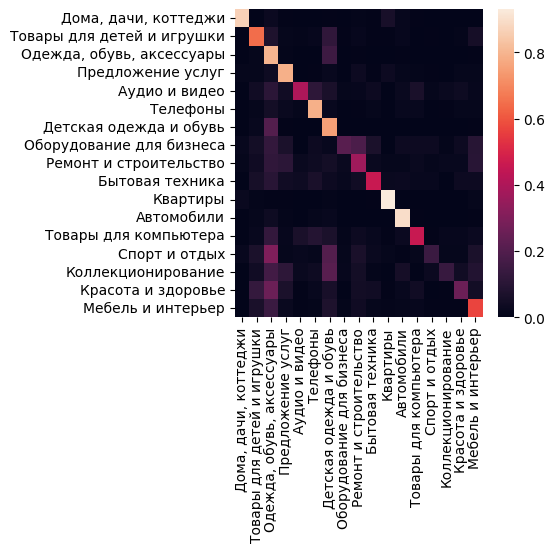

In [11]:
metrics = metrics_svd
errors = errors_svd

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [12]:
# NMF 

In [13]:
pipeline_nmf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100, l1_ratio=0.5)),
    ('clf', SGDClassifier(penalty="l2", alpha=0.001, learning_rate="optimal"))
])

In [14]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py

In [15]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.58           0.36    0.62        0.34   
Товары для детей и игрушки       0.73           0.33    0.26        0.19   
Одежда, обувь, аксессуары        0.59           0.17    0.62        0.20   
Предложение услуг                0.54           0.34    0.26        0.28   
Аудио и видео                    0.01           0.02    0.09        0.22   
Телефоны                         0.57           0.17    0.61        0.19   
Детская одежда и обувь           0.59           0.21    0.61        0.21   
Оборудование для бизнеса         0.00           0.00    0.00        0.00   
Ремонт и строительство           0.18           0.15    0.19        0.19   
Бытовая техника                  0.25           0.20    0.07        0.07   
Квартиры                         0.79           0.19    0.79        0.15   
Автомобили                       0.62           0.33    0.51        0.33   
Товары для компьютера            0.00           0.00    0.00        0.00   
Спорт и отдых                    0.08           0.20    0.01        0.02   
Коллекционирование               0.08           0.20    0.01        0.02   
Красота и здоровье               0.03           0.04    0.14        0.27   
Мебель и интерьер                0.36           0.35    0.09        0.09   
mean                             0.35           0.19    0.29        0.16   

                              f1  f1_std  
Дома, дачи, коттеджи        0.56    0.29  
Товары для детей и игрушки  0.29    0.10  
Одежда, обувь, аксессуары   0.56    0.08  
Предложение услуг           0.26    0.19  
Аудио и видео               0.01    0.03  
Телефоны                    0.55    0.04  
Детская одежда и обувь      0.54    0.09  
Оборудование для бизнеса    0.00    0.00  
Ремонт и строительство      0.17    0.15  
Бытовая техника             0.11    0.10  
Квартиры                    0.76    0.08  
Автомобили                  0.52    0.27  
Товары для компьютера       0.00    0.00  
Спорт и отдых               0.01    0.03  
Коллекционирование          0.02    0.04  
Красота и здоровье          0.04    0.04  
Мебель и интерьер           0.13    0.12  
mean                        0.27    0.10

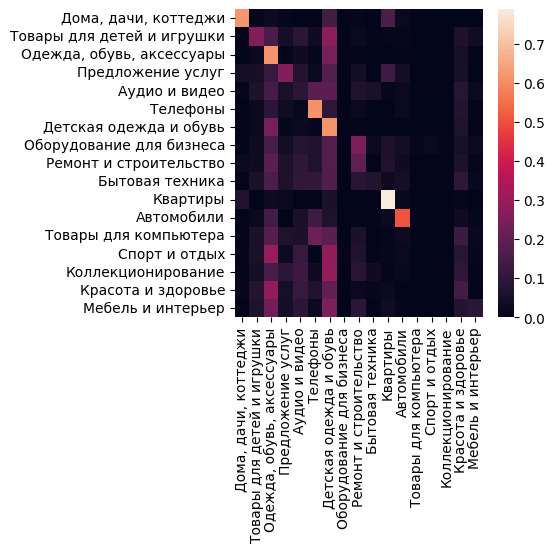

In [16]:
metrics = metrics_nmf
errors = errors_nmf

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [17]:
# LDA

In [18]:
texts = data['description_norm'].tolist()

dictionary = gensim.corpora.Dictionary((text.split() for text in texts))
dictionary.filter_extremes(no_above=0.1, no_below=10)
dictionary.compactify()

corpus = [dictionary.doc2bow(text.split()) for text in texts]

In [19]:
lda = gensim.models.LdaModel(corpus, 150, id2word=dictionary, passes=7)

In [20]:
pyLDAvis.enable_notebook()

In [21]:
def get_lda_metrics(model):
    topics = []
    for topic_id, topic in model.show_topics(num_topics=100, formatted=False):
        topic = [word for word, _ in topic]
        topics.append(topic)

    coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                    texts=[text.split() for text in texts], 
                                                    dictionary=dictionary, coherence='c_v')

    
    print("Perplexity: %.2f" % np.exp2(-model.log_perplexity(corpus[:1000])))
    print("Coherence: %.2f" % coherence_model_lda.get_coherence())

In [22]:
get_lda_metrics(lda)

Perplexity: 946.09
Coherence: 0.45


In [23]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
46    -0.183874 -0.154383       1        1  1.871021
31    -0.200595 -0.135694       2        1  1.661096
74    -0.267222  0.191774       3        1  1.649574
133   -0.108313 -0.217305       4        1  1.644829
16    -0.184808  0.168195       5        1  1.592782
...         ...       ...     ...      ...       ...
4      0.042675  0.011766     146        1  0.266675
49     0.060110 -0.029989     147        1  0.247862
71     0.019948 -0.060370     148        1  0.245769
22     0.061859  0.005276     149        1  0.218378
1      0.075466  0.029707     150        1  0.213887

[150 rows x 5 columns], topic_info=           Term        Freq       Total  Category  logprob  loglift
635           —  963.000000  963.000000   Default  30.0000  30.0000
53            р  717.000000  717.000000   Default  29.0000  29.0000
18         торг  623.000000  623.000000   Default  28.0000  28.0000
37            у  686.000000  686.000000   Default  27.0000  27.0000
40        очень  748.000000  748.000000   Default  26.0000  26.0000
..          ...         ...         ...       ...      ...      ...
121         два    2.743405  412.966833  Topic150  -4.6656   1.1333
307  посмотреть    0.171162   69.391405  Topic150  -7.4399   0.1426
25            2    1.094857  977.126347  Topic150  -5.5841  -0.6465
193     ребёнок    0.445963  319.978571  Topic150  -6.4823  -0.4283
797          16    0.266490  175.768772  Topic150  -6.9972  -0.3441

[5775 rows x 6 columns], token_table=      Topic      Freq Term
term                      
404      10  0.944309    0
404     110  0.049183    0
1327     53  0.396775  0,5
1327    140  0.566821  0,5
1956     10  0.009848   00
...     ...       ...  ...
1709    122  0.995366    •
1846    103  0.984398    ₽
1626      6  0.468942    №
1626      8  0.337052    №
1626     39  0.190508    №

[7127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[47, 32, 75, 134, 17, 76, 37, 58, 93, 45, 91, 120, 13, 44, 130, 14, 88, 65, 96, 49, 70, 3, 90, 74, 87, 92, 73, 35, 89, 150, 30, 102, 115, 101, 54, 110, 136, 122, 113, 83, 55, 48, 25, 148, 119, 118, 108, 18, 56, 67, 138, 81, 29, 1, 84, 51, 106, 24, 109, 71, 77, 140, 9, 64, 133, 139, 59, 94, 52, 19, 60, 69, 142, 66, 144, 100, 114, 98, 16, 22, 42, 43, 95, 82, 61, 104, 85, 129, 38, 105, 26, 12, 21, 141, 8, 143, 135, 11, 78, 62, 57, 86, 53, 10, 116, 6, 126, 149, 34, 103, 124, 121, 128, 15, 46, 31, 80, 145, 41, 7, 39, 132, 107, 36, 117, 20, 27, 127, 131, 63, 123, 28, 99, 79, 4, 97, 146, 125, 40, 68, 112, 147, 111, 33, 137, 5, 50, 72, 23, 2])

### KNeighborsCLassifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=7, weights='distance')

In [25]:
# SVD

In [26]:
pipeline_svd_kn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', kn)
])

In [27]:
metrics_svd_kn, errors_svd_kn = eval_table(data['description_norm'], data['category_name'], pipeline_svd_kn)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_patt

In [28]:
metrics_svd_kn

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.79           0.12    0.61        0.13   
Товары для детей и игрушки       0.43           0.06    0.25        0.07   
Одежда, обувь, аксессуары        0.42           0.02    0.60        0.04   
Предложение услуг                0.48           0.05    0.58        0.02   
Аудио и видео                    0.27           0.05    0.12        0.03   
Телефоны                         0.61           0.07    0.39        0.09   
Детская одежда и обувь           0.44           0.04    0.61        0.03   
Оборудование для бизнеса         0.19           0.19    0.08        0.09   
Ремонт и строительство           0.27           0.06    0.20        0.03   
Бытовая техника                  0.33           0.09    0.25        0.04   
Квартиры                         0.91           0.04    0.60        0.07   
Автомобили                       0.52           0.07    0.45        0.03   
Товары для компьютера            0.38           0.17    0.16        0.09   
Спорт и отдых                    0.02           0.06    0.01        0.02   
Коллекционирование               0.09           0.04    0.09        0.04   
Красота и здоровье               0.19           0.11    0.06        0.04   
Мебель и интерьер                0.33           0.04    0.21        0.04   
mean                             0.39           0.08    0.31        0.05   

                              f1  f1_std  
Дома, дачи, коттеджи        0.68    0.09  
Товары для детей и игрушки  0.32    0.07  
Одежда, обувь, аксессуары   0.49    0.02  
Предложение услуг           0.53    0.03  
Аудио и видео               0.17    0.04  
Телефоны                    0.47    0.08  
Детская одежда и обувь      0.51    0.04  
Оборудование для бизнеса    0.11    0.11  
Ремонт и строительство      0.23    0.04  
Бытовая техника             0.28    0.05  
Квартиры                    0.72    0.05  
Автомобили                  0.48    0.02  
Товары для компьютера       0.23    0.11  
Спорт и отдых               0.01    0.02  
Коллекционирование          0.09    0.04  
Красота и здоровье          0.09    0.06  
Мебель и интерьер           0.25    0.04  
mean                        0.33    0.05

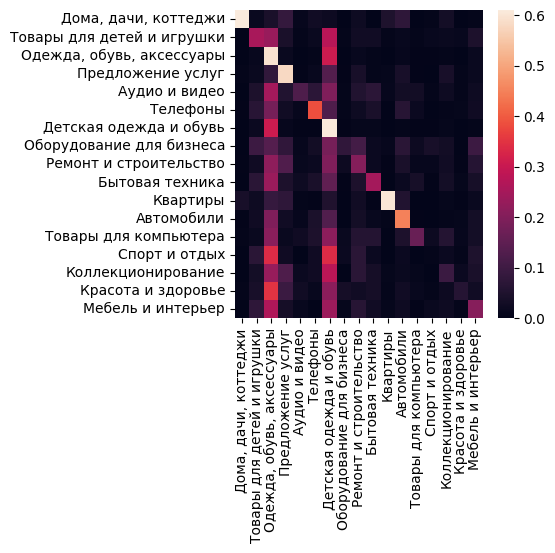

In [29]:
metrics = metrics_svd_kn
errors = errors_svd_kn

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [30]:
# NMF 

In [31]:
pipeline_nmf_kn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100, l1_ratio=0.5)),
    ('clf', kn)
])

In [32]:
metrics_nmf_kn, errors_nmf_kn = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_kn)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_patt

In [33]:
metrics_nmf_kn

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.81           0.09    0.68        0.08   
Товары для детей и игрушки       0.36           0.07    0.32        0.07   
Одежда, обувь, аксессуары        0.48           0.02    0.57        0.03   
Предложение услуг                0.44           0.05    0.71        0.06   
Аудио и видео                    0.14           0.09    0.09        0.06   
Телефоны                         0.55           0.08    0.46        0.10   
Детская одежда и обувь           0.52           0.03    0.50        0.04   
Оборудование для бизнеса         0.18           0.24    0.06        0.04   
Ремонт и строительство           0.21           0.04    0.19        0.04   
Бытовая техника                  0.24           0.09    0.21        0.05   
Квартиры                         0.73           0.13    0.78        0.08   
Автомобили                       0.62           0.15    0.62        0.14   
Товары для компьютера            0.25           0.08    0.24        0.07   
Спорт и отдых                    0.06           0.10    0.02        0.04   
Коллекционирование               0.07           0.06    0.03        0.03   
Красота и здоровье               0.10           0.10    0.05        0.05   
Мебель и интерьер                0.27           0.11    0.25        0.10   
mean                             0.35           0.09    0.34        0.06   

                              f1  f1_std  
Дома, дачи, коттеджи        0.74    0.07  
Товары для детей и игрушки  0.33    0.06  
Одежда, обувь, аксессуары   0.52    0.02  
Предложение услуг           0.54    0.05  
Аудио и видео               0.11    0.07  
Телефоны                    0.50    0.09  
Детская одежда и обувь      0.51    0.03  
Оборудование для бизнеса    0.08    0.06  
Ремонт и строительство      0.20    0.04  
Бытовая техника             0.22    0.07  
Квартиры                    0.75    0.11  
Автомобили                  0.61    0.12  
Товары для компьютера       0.24    0.06  
Спорт и отдых               0.03    0.06  
Коллекционирование          0.04    0.04  
Красота и здоровье          0.07    0.07  
Мебель и интерьер           0.26    0.10  
mean                        0.34    0.07

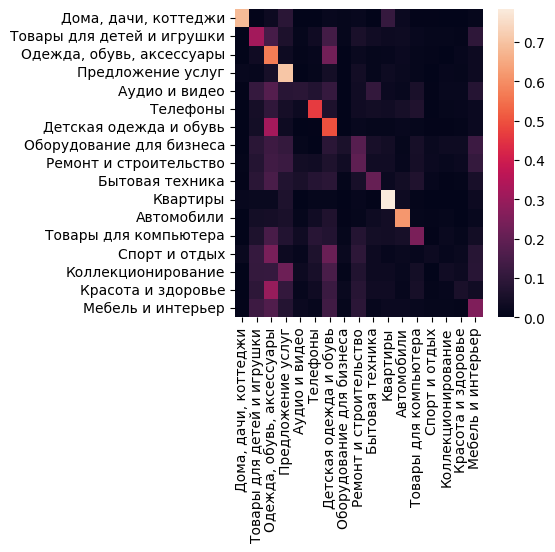

In [34]:
metrics = metrics_nmf_kn
errors = errors_nmf_kn

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [35]:
# LDA

In [36]:
lda_kn = gensim.models.LdaModel(corpus, 150, id2word=dictionary, passes=7)

In [37]:
get_lda_metrics(lda_kn)

Perplexity: 956.36
Coherence: 0.46


In [38]:
pyLDAvis.gensim_models.prepare(lda_kn, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.055053 -0.134075       1        1  2.626422
55     0.019525 -0.167584       2        1  2.205710
6      0.047309 -0.138206       3        1  1.565076
74    -0.249777 -0.107250       4        1  1.520893
24    -0.288862 -0.064272       5        1  1.425192
...         ...       ...     ...      ...       ...
102    0.057726 -0.016082     146        1  0.302870
7      0.048475 -0.042525     147        1  0.298065
50     0.058948  0.037939     148        1  0.295905
115    0.047847 -0.006277     149        1  0.286273
72     0.062751  0.041582     150        1  0.203322

[150 rows x 5 columns], topic_info=          Term        Freq       Total  Category  logprob  loglift
635          —  957.000000  957.000000   Default  30.0000  30.0000
53           р  728.000000  728.000000   Default  29.0000  29.0000
66           1  788.000000  788.000000   Default  28.0000  28.0000
60          за  829.000000  829.000000   Default  27.0000  27.0000
472          м  631.000000  631.000000   Default  26.0000  26.0000
..         ...         ...         ...       ...      ...      ...
718     купить    0.007382  216.197555  Topic150 -10.5328  -4.0867
351      любой    0.007382  496.963658  Topic150 -10.5328  -4.9191
112  возможный    0.007382  279.410627  Topic150 -10.5328  -4.3432
84    исправно    0.007382   21.454463  Topic150 -10.5328  -1.7765
42     удобный    0.007382  377.219438  Topic150 -10.5328  -4.6434

[5738 rows x 6 columns], token_table=      Topic      Freq Term
term                      
404      25  0.782931    0
404      69  0.210055    0
1327     43  0.968181  0,5
1956     25  0.009135   00
1956     26  0.045673   00
...     ...       ...  ...
1626      1  0.333971    №
1626     37  0.261368    №
1626     77  0.116164    №
1626     91  0.275889    №
1626    129  0.014520    №

[7358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 56, 7, 75, 25, 33, 93, 148, 106, 10, 110, 50, 140, 118, 41, 142, 76, 120, 100, 126, 146, 1, 60, 58, 90, 85, 66, 32, 35, 123, 98, 12, 134, 105, 113, 92, 43, 67, 64, 111, 82, 121, 39, 15, 68, 136, 150, 34, 149, 23, 20, 86, 77, 78, 61, 44, 109, 87, 38, 19, 21, 129, 141, 125, 28, 112, 47, 49, 31, 124, 46, 30, 42, 114, 147, 132, 83, 137, 36, 144, 63, 27, 22, 127, 117, 108, 9, 101, 26, 52, 71, 54, 102, 2, 119, 17, 133, 16, 69, 89, 4, 88, 130, 29, 84, 122, 143, 94, 79, 139, 80, 131, 14, 6, 55, 59, 96, 95, 107, 62, 18, 13, 24, 81, 5, 37, 70, 48, 99, 138, 53, 115, 45, 40, 104, 128, 91, 65, 74, 135, 57, 97, 72, 145, 11, 103, 8, 51, 116, 73])

### RandomForest

In [39]:
rf = RandomForestClassifier(n_estimators=120, max_features="log2")

In [40]:
# SVD

In [41]:
pipeline_svd_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', rf)
])

In [42]:
metrics_svd_rf, errors_svd_rf = eval_table(data['description_norm'], data['category_name'], pipeline_svd_rf)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

In [43]:
metrics_svd_rf

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.91           0.09    0.33        0.11   
Товары для детей и игрушки       0.64           0.09    0.20        0.04   
Одежда, обувь, аксессуары        0.39           0.01    0.73        0.02   
Предложение услуг                0.73           0.06    0.37        0.05   
Аудио и видео                    0.58           0.49    0.03        0.03   
Телефоны                         0.84           0.10    0.34        0.07   
Детская одежда и обувь           0.38           0.02    0.73        0.03   
Оборудование для бизнеса         0.58           0.49    0.04        0.03   
Ремонт и строительство           0.53           0.12    0.05        0.03   
Бытовая техника                  0.51           0.15    0.11        0.04   
Квартиры                         0.73           0.04    0.82        0.05   
Автомобили                       0.75           0.07    0.42        0.06   
Товары для компьютера            0.50           0.55    0.02        0.02   
Спорт и отдых                    0.00           0.00    0.00        0.00   
Коллекционирование               0.00           0.00    0.00        0.00   
Красота и здоровье               0.00           0.00    0.00        0.00   
Мебель и интерьер                0.67           0.23    0.07        0.04   
mean                             0.51           0.15    0.25        0.04   

                              f1  f1_std  
Дома, дачи, коттеджи        0.47    0.12  
Товары для детей и игрушки  0.31    0.05  
Одежда, обувь, аксессуары   0.51    0.01  
Предложение услуг           0.49    0.06  
Аудио и видео               0.06    0.05  
Телефоны                    0.48    0.08  
Детская одежда и обувь      0.50    0.02  
Оборудование для бизнеса    0.07    0.06  
Ремонт и строительство      0.08    0.04  
Бытовая техника             0.18    0.06  
Квартиры                    0.77    0.02  
Автомобили                  0.53    0.06  
Товары для компьютера       0.03    0.03  
Спорт и отдых               0.00    0.00  
Коллекционирование          0.00    0.00  
Красота и здоровье          0.00    0.00  
Мебель и интерьер           0.13    0.06  
mean                        0.27    0.04

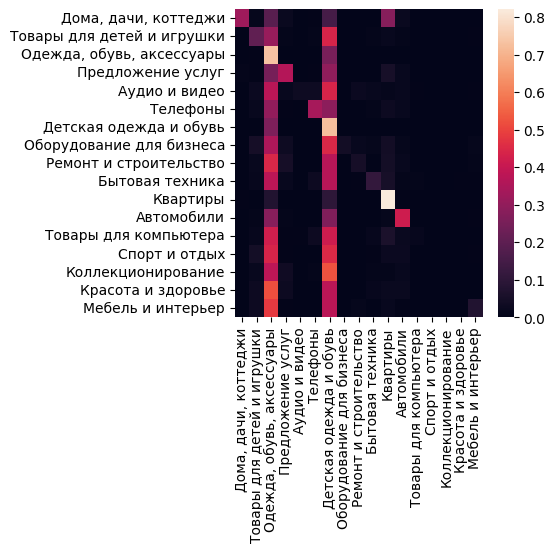

In [44]:
metrics = metrics_svd_rf
errors = errors_svd_rf

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [45]:
# NMF 

In [46]:
pipeline_nmf_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100, l1_ratio=0.5)),
    ('clf', rf)
])

In [47]:
metrics_nmf_rf, errors_nmf_rf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_rf)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py

In [48]:
metrics_nmf_rf

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.88           0.08    0.80        0.06   
Товары для детей и игрушки       0.66           0.04    0.56        0.06   
Одежда, обувь, аксессуары        0.60           0.03    0.78        0.03   
Предложение услуг                0.63           0.04    0.76        0.05   
Аудио и видео                    0.66           0.11    0.25        0.04   
Телефоны                         0.68           0.04    0.77        0.04   
Детская одежда и обувь           0.64           0.03    0.77        0.04   
Оборудование для бизнеса         0.33           0.41    0.05        0.07   
Ремонт и строительство           0.43           0.05    0.30        0.03   
Бытовая техника                  0.63           0.11    0.28        0.05   
Квартиры                         0.89           0.03    0.94        0.04   
Автомобили                       0.76           0.03    0.91        0.04   
Товары для компьютера            0.56           0.06    0.41        0.07   
Спорт и отдых                    0.39           0.39    0.04        0.03   
Коллекционирование               0.00           0.00    0.00        0.00   
Красота и здоровье               0.22           0.40    0.01        0.02   
Мебель и интерьер                0.63           0.07    0.50        0.07   
mean                             0.56           0.11    0.48        0.04   

                              f1  f1_std  
Дома, дачи, коттеджи        0.84    0.05  
Товары для детей и игрушки  0.61    0.04  
Одежда, обувь, аксессуары   0.67    0.03  
Предложение услуг           0.69    0.03  
Аудио и видео               0.36    0.05  
Телефоны                    0.72    0.03  
Детская одежда и обувь      0.70    0.02  
Оборудование для бизнеса    0.09    0.12  
Ремонт и строительство      0.36    0.03  
Бытовая техника             0.39    0.06  
Квартиры                    0.91    0.02  
Автомобили                  0.83    0.03  
Товары для компьютера       0.47    0.06  
Спорт и отдых               0.07    0.06  
Коллекционирование          0.00    0.00  
Красота и здоровье          0.03    0.04  
Мебель и интерьер           0.56    0.06  
mean                        0.49    0.04

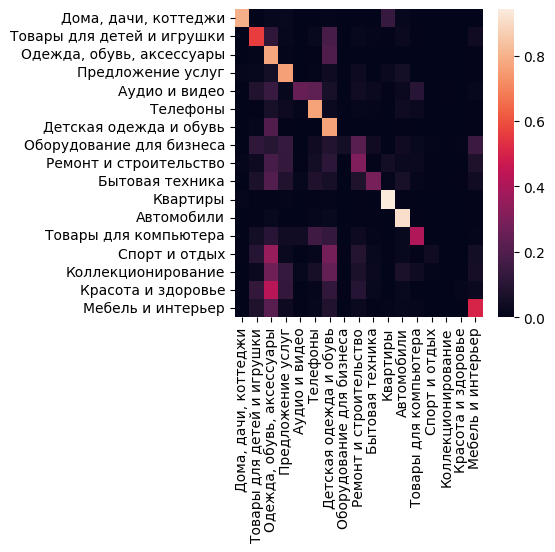

In [49]:
metrics = metrics_nmf_rf
errors = errors_nmf_rf

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [50]:
# LDA

In [51]:
lda_rf = gensim.models.LdaModel(corpus, 150, id2word=dictionary, passes=7)

In [52]:
pyLDAvis.gensim_models.prepare(lda_rf, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
92    -0.166893 -0.238532       1        1  2.068344
84    -0.068867 -0.318192       2        1  2.058882
21    -0.201403  0.057758       3        1  2.055544
48    -0.052444 -0.299592       4        1  2.012101
61    -0.265894  0.102859       5        1  1.976957
...         ...       ...     ...      ...       ...
59     0.072051 -0.068166     146        1  0.261789
130    0.063878  0.001849     147        1  0.257988
89     0.056224  0.033739     148        1  0.253511
87     0.070441  0.012351     149        1  0.242675
50     0.039696  0.016375     150        1  0.226031

[150 rows x 5 columns], topic_info=        Term         Freq        Total  Category  logprob  loglift
635        —  1016.000000  1016.000000   Default  30.0000  30.0000
53         р   723.000000   723.000000   Default  29.0000  29.0000
40     очень   741.000000   741.000000   Default  28.0000  28.0000
66         1   782.000000   782.000000   Default  27.0000  27.0000
60        за   847.000000   847.000000   Default  26.0000  26.0000
...      ...          ...          ...       ...      ...      ...
230      это     0.006724   223.496432  Topic150 -10.7320  -4.3192
273        к     0.006717   421.167926  Topic150 -10.7330  -4.9538
1221     160     0.006703    33.728546  Topic150 -10.7352  -2.4313
509        6     0.006697   322.672076  Topic150 -10.7360  -4.6904
319   работа     0.006697   372.658305  Topic150 -10.7361  -4.8345

[5738 rows x 6 columns], token_table=      Topic      Freq Term
term                      
404      32  0.615247    0
404      41  0.369148    0
1327     54  0.949563  0,5
1956     18  0.038821   00
1956     39  0.941418   00
...     ...       ...  ...
1846    147  0.991693    ₽
1626      2  0.089432    №
1626      5  0.059622    №
1626      7  0.149054    №
1626    100  0.685648    №

[7150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[93, 85, 22, 49, 62, 15, 72, 57, 50, 39, 38, 89, 56, 64, 65, 123, 125, 119, 102, 149, 43, 106, 23, 29, 54, 24, 1, 16, 4, 61, 76, 67, 114, 118, 35, 121, 87, 47, 100, 132, 46, 117, 113, 75, 45, 120, 3, 150, 134, 77, 34, 80, 147, 94, 41, 92, 126, 115, 59, 83, 71, 17, 30, 148, 32, 70, 124, 2, 26, 138, 127, 74, 141, 31, 144, 122, 98, 69, 66, 20, 136, 68, 116, 28, 142, 128, 8, 53, 79, 7, 73, 96, 40, 112, 137, 44, 37, 82, 103, 130, 86, 25, 42, 12, 6, 105, 33, 9, 110, 139, 109, 135, 81, 99, 55, 19, 97, 21, 108, 48, 84, 104, 18, 143, 13, 140, 91, 14, 52, 27, 111, 129, 145, 78, 10, 107, 101, 95, 58, 63, 11, 36, 146, 133, 5, 60, 131, 90, 88, 51])

In [53]:
get_lda_metrics(lda_rf)

Perplexity: 899.94
Coherence: 0.43


### ExtraTreesClassifier

In [54]:
xtra = ExtraTreesClassifier(n_estimators=110, criterion="entropy")

In [55]:
# SVD

In [56]:
pipeline_svd_xtra = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', xtra)
])

In [57]:
metrics_svd_xtra, errors_svd_xtra = eval_table(data['description_norm'], data['category_name'], pipeline_svd_xtra)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

In [58]:
metrics_svd_xtra

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.91           0.10    0.18        0.05   
Товары для детей и игрушки       0.59           0.16    0.13        0.04   
Одежда, обувь, аксессуары        0.36           0.01    0.71        0.01   
Предложение услуг                0.76           0.07    0.20        0.04   
Аудио и видео                    0.58           0.49    0.04        0.04   
Телефоны                         0.81           0.04    0.25        0.03   
Детская одежда и обувь           0.35           0.01    0.70        0.02   
Оборудование для бизнеса         0.17           0.26    0.02        0.03   
Ремонт и строительство           0.37           0.17    0.04        0.03   
Бытовая техника                  0.54           0.14    0.13        0.04   
Квартиры                         0.67           0.05    0.67        0.03   
Автомобили                       0.71           0.09    0.30        0.06   
Товары для компьютера            0.58           0.49    0.03        0.02   
Спорт и отдых                    0.17           0.41    0.01        0.02   
Коллекционирование               0.17           0.41    0.01        0.02   
Красота и здоровье               0.00           0.00    0.00        0.00   
Мебель и интерьер                0.67           0.10    0.05        0.02   
mean                             0.49           0.18    0.20        0.03   

                              f1  f1_std  
Дома, дачи, коттеджи        0.30    0.07  
Товары для детей и игрушки  0.22    0.06  
Одежда, обувь, аксессуары   0.48    0.01  
Предложение услуг           0.32    0.06  
Аудио и видео               0.08    0.07  
Телефоны                    0.39    0.04  
Детская одежда и обувь      0.47    0.01  
Оборудование для бизнеса    0.04    0.05  
Ремонт и строительство      0.07    0.04  
Бытовая техника             0.21    0.05  
Квартиры                    0.67    0.04  
Автомобили                  0.42    0.06  
Товары для компьютера       0.05    0.04  
Спорт и отдых               0.01    0.03  
Коллекционирование          0.02    0.04  
Красота и здоровье          0.00    0.00  
Мебель и интерьер           0.10    0.04  
mean                        0.23    0.04

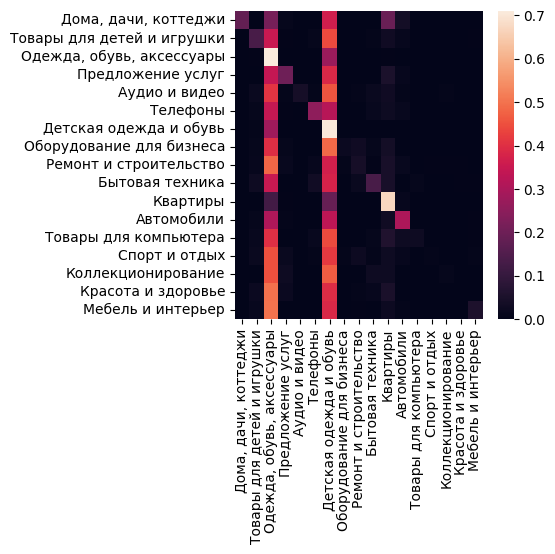

In [59]:
metrics = metrics_svd_xtra
errors = errors_svd_xtra

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [60]:
# NMF 

In [61]:
pipeline_nmf_xtra = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100, l1_ratio=0.5)),
    ('clf', xtra)
])

In [62]:
metrics_nmf_xtra, errors_nmf_xtra = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_xtra)

/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/dolgov/temp/things/.tvenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/user/dolg

In [63]:
metrics_nmf_xtra

precision  precision_std  recall  recall_std  \
Дома, дачи, коттеджи             0.84           0.09    0.83        0.07   
Товары для детей и игрушки       0.66           0.05    0.54        0.03   
Одежда, обувь, аксессуары        0.58           0.02    0.78        0.02   
Предложение услуг                0.61           0.04    0.75        0.05   
Аудио и видео                    0.58           0.24    0.17        0.06   
Телефоны                         0.69           0.07    0.79        0.05   
Детская одежда и обувь           0.66           0.03    0.75        0.02   
Оборудование для бизнеса         0.56           0.50    0.04        0.03   
Ремонт и строительство           0.44           0.07    0.30        0.06   
Бытовая техника                  0.55           0.10    0.28        0.07   
Квартиры                         0.88           0.03    0.94        0.02   
Автомобили                       0.76           0.06    0.92        0.06   
Товары для компьютера            0.60           0.09    0.38        0.08   
Спорт и отдых                    0.50           0.33    0.05        0.03   
Коллекционирование               0.36           0.43    0.03        0.04   
Красота и здоровье               0.18           0.21    0.02        0.02   
Мебель и интерьер                0.63           0.08    0.45        0.10   
mean                             0.59           0.14    0.47        0.05   

                              f1  f1_std  
Дома, дачи, коттеджи        0.83    0.06  
Товары для детей и игрушки  0.59    0.02  
Одежда, обувь, аксессуары   0.66    0.01  
Предложение услуг           0.67    0.03  
Аудио и видео               0.26    0.09  
Телефоны                    0.74    0.05  
Детская одежда и обувь      0.70    0.02  
Оборудование для бизнеса    0.07    0.06  
Ремонт и строительство      0.35    0.07  
Бытовая техника             0.37    0.08  
Квартиры                    0.91    0.02  
Автомобили                  0.83    0.04  
Товары для компьютера       0.47    0.07  
Спорт и отдых               0.09    0.05  
Коллекционирование          0.06    0.08  
Красота и здоровье          0.04    0.04  
Мебель и интерьер           0.52    0.07  
mean                        0.48    0.05

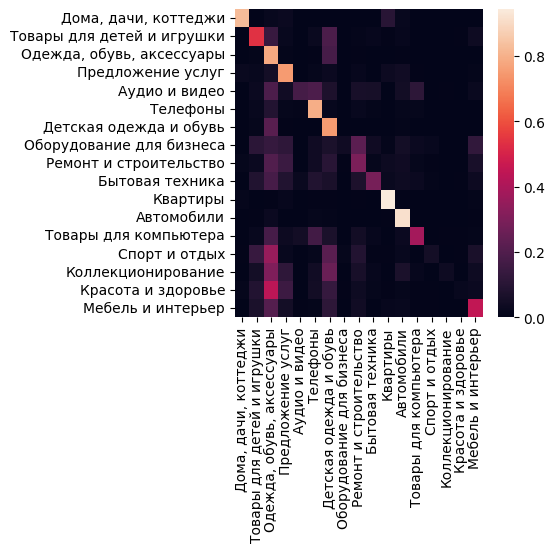

In [64]:
metrics = metrics_nmf_xtra
errors = errors_nmf_xtra

plt.figure(figsize=(4, 4))
sns.heatmap(errors, xticklabels=metrics.index.tolist()[:-1], 
            yticklabels=metrics.index.tolist()[:-1])
plt.show()

In [65]:
# LDA

In [66]:
lda_xtra = gensim.models.LdaModel(corpus, 150, id2word=dictionary, passes=7)

In [67]:
pyLDAvis.gensim_models.prepare(lda_xtra, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.298463  0.040184       1        1  1.950652
126   -0.015578  0.331644       2        1  1.918922
46    -0.057837  0.027607       3        1  1.908004
60    -0.036458 -0.005502       4        1  1.836539
137    0.053022  0.243001       5        1  1.698070
...         ...       ...     ...      ...       ...
61    -0.047516 -0.053393     146        1  0.244741
100   -0.049146 -0.000129     147        1  0.243595
69    -0.042000 -0.054948     148        1  0.241083
48    -0.041935 -0.055541     149        1  0.218698
63    -0.037743 -0.063764     150        1  0.205979

[150 rows x 5 columns], topic_info=         Term        Freq       Total  Category  logprob  loglift
635         —  952.000000  952.000000   Default  30.0000  30.0000
53          р  721.000000  721.000000   Default  29.0000  29.0000
37          у  685.000000  685.000000   Default  28.0000  28.0000
472         м  610.000000  610.000000   Default  27.0000  27.0000
18       торг  629.000000  629.000000   Default  26.0000  26.0000
...       ...         ...         ...       ...      ...      ...
2262   ксенон    0.008045   11.486021  Topic150 -10.4598  -1.0787
368   подарок    0.008384  193.005096  Topic150 -10.4185  -3.8590
521   комфорт    0.008036   33.059397  Topic150 -10.4610  -2.1370
1832    кофта    0.007975   50.074465  Topic150 -10.4685  -2.5598
840    высота    0.008016  256.320145  Topic150 -10.4634  -4.1876

[5728 rows x 6 columns], token_table=      Topic      Freq Term
term                      
404      17  0.992844    0
1327     99  0.955659  0,5
1956     17  0.009676   00
1956     44  0.358025   00
1956     57  0.580580   00
...     ...       ...  ...
1626      5  0.163382    №
1626     12  0.623824    №
1626     16  0.074265    №
1626     24  0.014853    №
1626     28  0.118824    №

[7039 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 127, 47, 61, 138, 119, 81, 90, 39, 134, 4, 41, 73, 48, 30, 108, 147, 85, 18, 103, 53, 92, 115, 83, 88, 132, 110, 143, 123, 3, 112, 32, 100, 13, 5, 130, 146, 142, 42, 74, 140, 23, 33, 79, 35, 40, 80, 2, 96, 106, 148, 136, 139, 133, 114, 120, 34, 15, 87, 28, 46, 26, 137, 126, 145, 52, 102, 109, 68, 59, 67, 117, 93, 20, 66, 57, 6, 94, 84, 69, 98, 131, 9, 29, 122, 37, 16, 45, 21, 91, 8, 25, 78, 89, 38, 14, 149, 12, 141, 118, 128, 124, 111, 72, 105, 97, 60, 1, 31, 107, 104, 76, 17, 27, 11, 75, 36, 99, 121, 54, 150, 44, 56, 95, 125, 86, 144, 82, 71, 24, 55, 43, 50, 51, 116, 65, 22, 19, 113, 58, 129, 63, 77, 10, 135, 62, 101, 70, 49, 64])

In [68]:
get_lda_metrics(lda_xtra)

Perplexity: 890.06
Coherence: 0.43


#### Итоги:

- лучшие модели по perplexity / coherence: KNeighbours LDA, RandomForest LDA

- лучшая модель по f1: SGD SVF

### Задание № 2 (2 балла)

С помощью gensim постройте 5 тематических моделей с разными параметрами. Как минимум попробуйте: разное количество тем, alpha и eta параметры (в альфа попробуйте "asymmetric" и "auto" помимо 'symmetric' по дефолту, в eta просто попробуйте разные значения), а также разные параметры фильтрации словаря. 

Оцените каждую из моделей с помощью метрик (перплексии и когерентности), а также визуально, просмотрев получаемые темы. Найдите самую хорошую тему для каждой из моделей.

In [75]:
# them model 1

lda_1 = gensim.models.LdaModel(corpus, id2word=dictionary, passes=5, 
                               num_topics=150, 
                               alpha="symmetric",
                               eta=1)
get_lda_metrics(lda_1)
lda_1.print_topics()

Perplexity: 1025.49
Coherence: 0.42


[(146,
  '0.022*"есть" + 0.013*"x" + 0.013*"игрушка" + 0.011*"колонка" + 0.008*"2" + 0.008*"музыкальный" + 0.007*"коврик" + 0.006*"usb" + 0.006*"разъём" + 0.005*"звук"'),
 (134,
  '0.000*"джинсы" + 0.000*"мебель" + 0.000*"талия" + 0.000*"стрейч" + 0.000*"низкий" + 0.000*"шкаф" + 0.000*"другой" + 0.000*"любой" + 0.000*"стена" + 0.000*"многое"'),
 (126,
  '0.012*"подарок" + 0.002*"ваш" + 0.002*"душа" + 0.001*"замечательный" + 0.001*"украшение" + 0.001*"достойный" + 0.001*"крем" + 0.001*"круг" + 0.001*"пинетка" + 0.001*"либо"'),
 (68,
  '0.000*"00" + 0.000*"11" + 0.000*"вы" + 0.000*"мы" + 0.000*"хотеть" + 0.000*"день" + 0.000*"звонить" + 0.000*"до" + 0.000*"волос" + 0.000*"17"'),
 (3,
  '0.000*"кровельный" + 0.000*"строительство" + 0.000*"дом" + 0.000*"наш" + 0.000*"компания" + 0.000*"2.0" + 0.000*"мы" + 0.000*"работа" + 0.000*"скидка" + 0.000*"вы"'),
 (116,
  '0.000*"подарок" + 0.000*"данный" + 0.000*"вентиляция" + 0.000*"видеонаблюдение" + 0.000*"2017" + 0.000*"охрана" + 0.000*"выбор" +

In [76]:
# them model 2

lda_2 = gensim.models.LdaModel(corpus, id2word=dictionary, passes=5, 
                               num_topics=100, 
                               alpha="asymmetric",
                               eta=5)
get_lda_metrics(lda_2)
lda_2.print_topics()

Perplexity: 671.78
Coherence: 0.44


[(99,
  '0.000*"х" + 0.000*"так" + 0.000*"как" + 0.000*"унитаз" + 0.000*"быть" + 0.000*"2" + 0.000*"дом" + 0.000*"удобный" + 0.000*"продавать" + 0.000*"за"'),
 (98,
  '0.083*"—" + 0.002*"система" + 0.002*"сидение" + 0.001*"обогрев" + 0.001*"руль" + 0.001*"стекло" + 0.001*"цвет" + 0.001*"дополнительный" + 0.001*"а" + 0.001*"обивка"'),
 (96,
  '0.000*"4" + 0.000*"—" + 0.000*"квартира" + 0.000*"2" + 0.000*"у" + 0.000*"цена" + 0.000*"блок" + 0.000*"из" + 0.000*"1" + 0.000*"650"'),
 (97,
  '0.000*"дом" + 0.000*"квартира" + 0.000*"да" + 0.000*"от" + 0.000*"до" + 0.000*"режим" + 0.000*"минута" + 0.000*"центр" + 0.000*"работа" + 0.000*"школа"'),
 (94,
  '0.000*"дом" + 0.000*"можно" + 0.000*"они" + 0.000*"2" + 0.000*"дуга" + 0.000*"коврик" + 0.000*"этаж" + 0.000*"к" + 0.000*"маленький" + 0.000*"у"'),
 (95,
  '0.000*"2" + 0.000*"r" + 0.000*"участок" + 0.000*"из" + 0.000*"любой" + 0.000*"о" + 0.000*"a" + 0.000*"р" + 0.000*"1" + 0.000*"шкаф"'),
 (93,
  '0.000*"из" + 0.000*"дом" + 0.000*"квартира" 

In [77]:
# them model 3

lda_3 = gensim.models.LdaModel(corpus, id2word=dictionary, passes=5, 
                               num_topics=90, 
                               alpha="auto",
                               eta=10)
get_lda_metrics(lda_3)
lda_3.print_topics()

Perplexity: 612.46
Coherence: 0.40


[(41,
  '0.000*"вещь" + 0.000*"другой" + 0.000*"один" + 0.000*"мм" + 0.000*"100" + 0.000*"из" + 0.000*"много" + 0.000*"удобный" + 0.000*"кузов" + 0.000*"за"'),
 (31,
  '0.000*"год" + 0.000*"х" + 0.000*"пара" + 0.000*"раз" + 0.000*"до" + 0.000*"00" + 0.000*"от" + 0.000*"мм" + 0.000*"наш" + 0.000*"кольцо"'),
 (17,
  '0.000*"защита" + 0.000*"предназначить" + 0.000*"устройство" + 0.000*"котёл" + 0.000*"процесс" + 0.000*"автоматический" + 0.000*"x" + 0.000*"есть" + 0.000*"вес" + 0.000*"к"'),
 (80,
  '0.000*"м" + 0.000*"50" + 0.000*"1" + 0.000*"стелька" + 0.000*"24" + 0.000*"2" + 0.000*"при" + 0.000*"мочь" + 0.000*"аккумулятор" + 0.000*"подошва"'),
 (74,
  '0.000*"рубль" + 0.000*"упаковка" + 0.000*"за" + 0.000*"30" + 0.000*"40" + 0.000*"крючок" + 0.000*"100" + 0.000*"станок" + 0.000*"производство" + 0.000*"карман"'),
 (47,
  '0.000*"1" + 0.000*"квартира" + 0.000*"б" + 0.000*"у" + 0.000*"ручка" + 0.000*"коляска" + 0.000*"р-р" + 0.000*"сезон" + 0.000*"мочь" + 0.000*"р"'),
 (40,
  '0.000*"работ

In [78]:
# them model 4

lda_4 = gensim.models.LdaModel(corpus, id2word=dictionary, passes=5, 
                               num_topics=120, 
                               alpha="asymmetric",
                               eta=3)
get_lda_metrics(lda_4)
lda_4.print_topics()

Perplexity: 640.17
Coherence: 0.44


[(119,
  '0.000*"есть" + 0.000*"маленький" + 0.000*"зеркало" + 0.000*"складывание" + 0.000*"книжка" + 0.000*"поддержка" + 0.000*"механизм" + 0.000*"она" + 0.000*"больший" + 0.000*"один"'),
 (118,
  '0.000*"работа" + 0.000*"час" + 0.000*"выполнять" + 0.000*"сложность" + 0.000*"другой" + 0.000*"товар" + 0.000*"место" + 0.000*"договорный" + 0.000*"расчёт" + 0.000*"цена"'),
 (115,
  '0.000*"задний" + 0.000*"автоматический" + 0.000*"передний" + 0.000*"колесо" + 0.000*"система" + 0.000*"фара" + 0.000*"скорость" + 0.000*"кг" + 0.000*"вид" + 0.000*"спортивный"'),
 (117,
  '0.033*"квартира" + 0.016*"дом" + 0.009*"ремонт" + 0.009*"детский" + 0.008*"—" + 0.008*"окно" + 0.007*"район" + 0.007*"мебель" + 0.006*"школа" + 0.006*"комната"'),
 (114,
  '0.000*"3" + 0.000*"поддержка" + 0.000*"цвет" + 0.000*"замена" + 0.000*"за" + 0.000*"технология" + 0.000*"4" + 0.000*"продавать" + 0.000*"вы" + 0.000*"мочь"'),
 (116,
  '0.000*"р" + 0.000*"за" + 0.000*"от" + 0.000*"кровля" + 0.000*"кв" + 0.000*"м" + 0.000*

In [79]:
# them model 5

lda_5 = gensim.models.LdaModel(corpus, id2word=dictionary, passes=5, 
                               num_topics=140, 
                               alpha="auto",
                               eta=2)
get_lda_metrics(lda_5)
lda_5.print_topics()

Perplexity: 698.95
Coherence: 0.46


[(30,
  '0.000*"»" + 0.000*"«" + 0.000*"100" + 0.000*"квартира" + 0.000*"из" + 0.000*"–" + 0.000*"сторона" + 0.000*"волос" + 0.000*"чистый" + 0.000*"раздельный"'),
 (35,
  '0.000*"х" + 0.000*"б" + 0.000*"указать" + 0.000*"подкладка" + 0.000*"носить" + 0.000*"ветровка" + 0.000*"74" + 0.000*"68" + 0.000*"год" + 0.000*"желание"'),
 (73,
  '0.000*"покраска" + 0.000*"ремонт" + 0.000*"но" + 0.000*"ручка" + 0.000*"коляска" + 0.000*"перекидной" + 0.000*"спинка" + 0.000*"регулировать" + 0.000*"стол" + 0.000*"дно"'),
 (58,
  '0.000*"я" + 0.000*"продавать" + 0.000*"36" + 0.000*"стеклоподъёмник" + 0.000*"зеркало" + 0.000*"кондиционер" + 0.000*"гур" + 0.000*"обмен" + 0.000*"аккуратно" + 0.000*"ножка"'),
 (128,
  '0.000*"работа" + 0.000*"строительный" + 0.000*"телефон" + 0.000*"мы" + 0.000*"кузов" + 0.000*"стоимость" + 0.000*"час" + 0.000*"магазин" + 0.000*"вы" + 0.000*"к"'),
 (139,
  '0.000*"цена" + 0.000*"очень" + 0.000*"за" + 0.000*"инструмент" + 0.000*"2" + 0.000*"специалист" + 0.000*"стаж" + 0.

#### Итоги 2:

- лучшая модель по perplexity: LDA3 (ppl 612)

- лучшая модель по coherence: LDA5 (coh 0.46)

#### Лучшие темы: 

- lda1 - (40,
  '0.002*"продавать" + 0.002*"ненадобность" + 0.001*"связь" + 0.001*"спутниковый" + 0.001*"машинка" + 0.001*"даже" + 0.001*"ссср" + 0.001*"время" + 0.001*"привод" + 0.001*"ножной"')
 
- lda2 - (8,
  '0.002*"замена" + 0.001*"установка" + 0.001*"розетка" + 0.001*"унитаз" + 0.001*"светильник" + 0.001*"монтаж" + 0.001*"люстра" + 0.001*"ремонт" + 0.001*"подключение" + 0.001*"раковина"')

- lda3 - (6,
  '0.000*"кожа" + 0.000*"натуральный" + 0.000*"стелька" + 0.000*"нат" + 0.000*"мех" + 0.000*"замша" + 0.000*"ботинок" + 0.000*"ортопедический" + 0.000*"внутри" + 0.000*"ботиночек"')

- lda4 - (8,
  '0.000*"дверь" + 0.000*"квартира" + 0.000*"окно" + 0.000*"межкомнатный" + 0.000*"дом" + 0.000*"пластиковый" + 0.000*"у" + 0.000*"продаваться" + 0.000*"комнатный" + 0.000*"металлический"')

- lda5 - (45,
  '0.038*"кожа" + 0.029*"натуральный" + 0.012*"сапог" + 0.008*"каблук" + 0.008*"замша" + 0.008*"мех" + 0.008*"кожаный" + 0.008*"туфля" + 0.005*"из" + 0.005*"чёрный"')